In [ ]:
import os
from time import sleep
from uuid import uuid4

import numpy as np

import GCode
import GRBL
from utils import picture


# Spindle Cutting Tests

## Objective
- Play around with Dremel High Speed Cutter 115 in the ER11 spindle

## Test Setup

- Oak Board 63mm x 300mm x 19mm
- Dremel High Speed Cutter "Carving / Engraving" 115.
- CSI3010SW dialed all the way up.

# Code:

In [4]:
cnc = GRBL.GRBL(port="/dev/cnc_3018")print("Laser Mode: {}".format(cnc.laser_mode))def init(feed=10):    program = GCode.GCode()    program.G21()  # Metric Units    program.G91()  # Absolute positioning.    program.G1(F=feed)    return programdef end():    program = GCode.GCode()    return program

Laser Mode: None


In [7]:
cnc.cmd("?")
cnc.reset()


In [13]:
cnc.cmd("!")
status1 = cnc.cmd("?")


In [14]:
cnc.cmd("!")
cnc.reset()
status2 = cnc.cmd("?")


In [29]:
for status in [status1, status2]:
    status_clean = [s for s in status if s != "ok"]
    print(status_clean)
    status_clean2 = [s.strip("<>") for s in status_clean]
    if len(status_clean2) != 1:
        raise Exception(status_clean2)
    status = status_clean2[0]
    print(status)
    stati = status.split("|")
    print(stati)
    print("")


['<Hold:0|MPos:-137.293,0.000,1.000|Bf:15,125|FS:0,0|Ov:100,100,100>']
Hold:0|MPos:-137.293,0.000,1.000|Bf:15,125|FS:0,0|Ov:100,100,100
['Hold:0', 'MPos:-137.293,0.000,1.000', 'Bf:15,125', 'FS:0,0', 'Ov:100,100,100']

['<Idle|MPos:-137.293,0.000,1.000|Bf:15,127|FS:0,0|WCO:0.000,0.000,0.000>']
Idle|MPos:-137.293,0.000,1.000|Bf:15,127|FS:0,0|WCO:0.000,0.000,0.000
['Idle', 'MPos:-137.293,0.000,1.000', 'Bf:15,127', 'FS:0,0', 'WCO:0.000,0.000,0.000']



In [64]:
def test_program(feed=10):
    prog = GCode.GCode()
    prog.M3(S=10000)
    dZ = -0.1
    dX = 10
    X = 0
    Z = 0
    for loops in range(20):
        prog.G1(Z=dZ, F=1)
        prog.G1(X=dX, F=feed)
        X += dX
        Z += dZ
    prog.M3(S=0)
    prog.G0(Z=np.round(-Z, 4))  # TODO: Add this to core library.
    prog.G0(X=np.round(-X, 4))
    prog.G0(Z=2)
    return prog


In [65]:
test_program()


<GCode>[cmds=45]

In [78]:
test_run = GCode.GCode()
# TODO: Get z-axis probe.
test_run += init()
for XFeed in [50]:
    test_run += test_program(feed=XFeed)


In [79]:
test_run


<GCode>[cmds=48]

In [80]:
gcode_file = "SpindleTests-Copy2.gcode"


In [81]:
test_run.save(gcode_file)

del test_run
test_run = GCode.GCode()

test_run.load(gcode_file)


In [82]:
test_run.buffer[0:5]


['G21', 'G91', 'G1 F10', 'M3 S10000', 'G1 Z-0.1 F1']

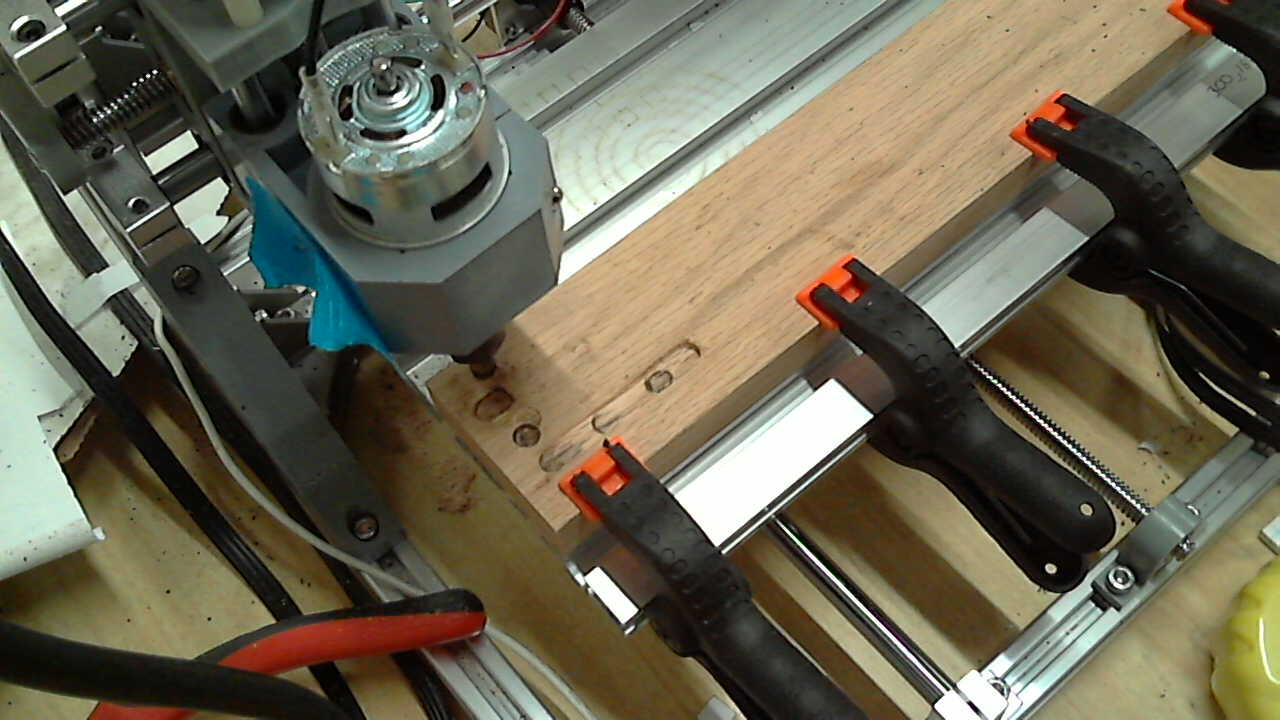

In [83]:
picture()


In [85]:
cnc.cmd("?")


['ok',
 '<Idle|MPos:-128.925,0.000,-1.200|Bf:15,127|FS:0,0|WCO:0.000,0.000,0.000>',
 'ok']

In [86]:
cnc.reset()


In [87]:
cnc.cmd("?")


['ok',
 '<Idle|MPos:-128.925,0.000,-1.200|Bf:15,127|FS:0,0|WCO:0.000,0.000,0.000>',
 'ok']

In [88]:
while 1:
    try:
        cnc.run(test_run)
        while 1:
            print(cnc.status)
            sleep(5)
    except KeyboardInterrupt as error:
        print("Feed Hold")
        cnc.cmd("!")
        while 1:
            try:
                cnc.reset()
                break
            except:
                pass
        print("^C")
        break
    except:
        raise


<Run|MPos:71.075,0.000,-2.531|Bf:12,127|FS:246,0|Ov:100,100,100>
<Run|MPos:18.079,0.000,-1.200|Bf:13,127|FS:800,0>
<Run|MPos:-49.334,0.000,-1.200|Bf:13,127|FS:800,0>
<Run|MPos:-116.768,0.000,-1.200|Bf:13,127|FS:800,0>
<Idle|MPos:-128.925,0.000,0.800|Bf:15,127|FS:0,0>
<Idle|MPos:-128.925,0.000,0.800|Bf:15,127|FS:0,0>
<Idle|MPos:-128.925,0.000,0.800|Bf:15,127|FS:0,0>
<Idle|MPos:-128.925,0.000,0.800|Bf:15,127|FS:0,0>
<Idle|MPos:-128.925,0.000,0.800|Bf:15,127|FS:0,0>
Feed Hold
^C


In [77]:
cnc.reset()


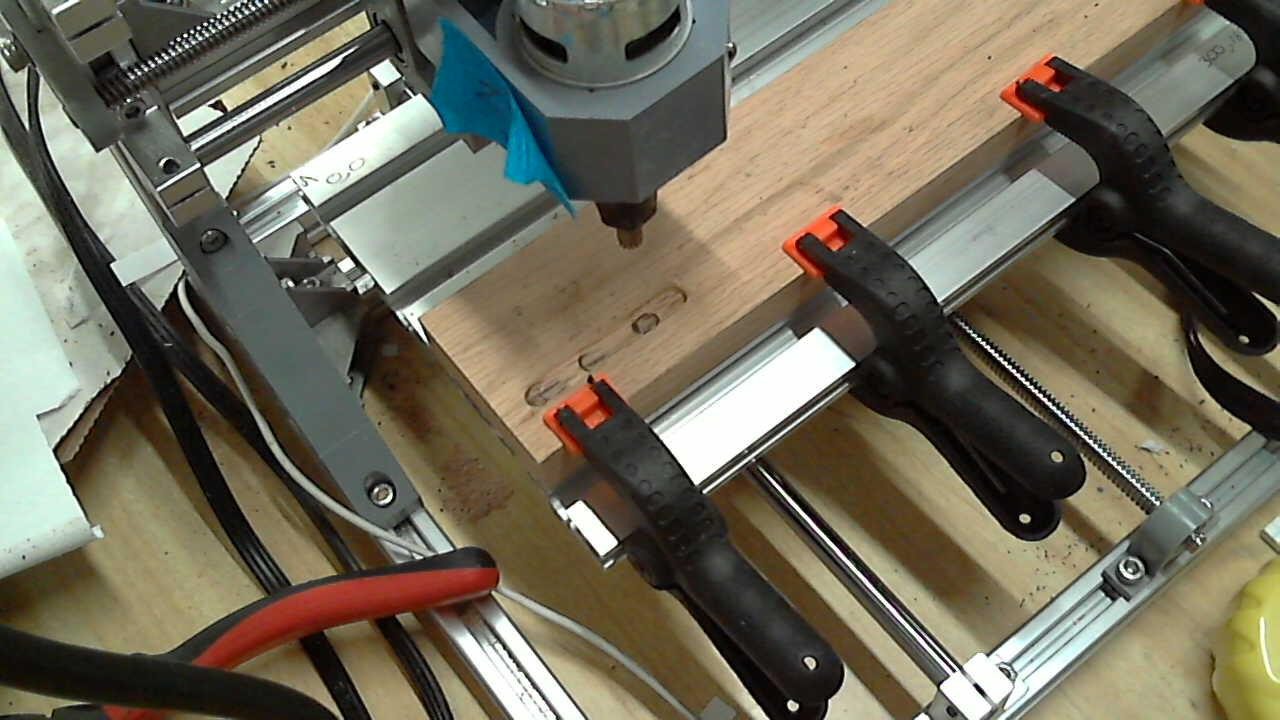

In [53]:
picture()


# Test Aborted.

Cuts were way too aggressive.